<a href="https://colab.research.google.com/github/rahmalianto/learning/blob/main/BwAI.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Setup

## Install library

google-genai merupakan library yang digunakan untuk berinteraksi dengan model-model Generative AI dari Google seperti Gemini. Informasi lebih lengkap dapat melalui link: https://ai.google.dev/gemini-api/docs?hl=id


In [14]:
!pip install -U --quiet google-genai

!pip install PyMuPDF
!pip install pydub

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 20.0/20.0 MB 39.0 MB/s eta 0:00:00


## Setting API key


1. Mendapatkan API Key
API Key adalah syarat untuk bisa mengakses Gemini API. Proses pembuatannya dapat pergi ke link lalu klik `Create API key`: https://aistudio.google.com/app/apikey
<center><img src="https://drive.google.com/uc?id=1DgUytDY1hL1bWUL8VcWOpnqtkJ90Fspe" width="700" style="float:right;">
</center>

2. Simpan di Google Colab secrets
Google colab secrets digunakan untuk mencegah keamanan. Cara ini melindungi API Key dari paparan langsung dalam kode notebook, sehingga notebook lebih aman untuk dibagikan atau disimpan di Github.
<center><img src="https://drive.google.com/uc?id=1eDHq0ucJ24cufmDWeaiyvTv1pxIQ7FnI" width="400" style="float:right;">
</center>

3. Mengambil API Key ke Notebook

In [126]:
from google.colab import userdata

api_key = userdata.get('GOOGLE_AI_STUDIO_API_KEY_PRO')

## Initialisasi SDK Client

In [3]:
from google import genai
from google.genai import types

client = genai.Client(api_key=api_key)

Mari memilih model yang akan digunakan. List model yang bisa digunakan bisa dilihat di: https://ai.google.dev/gemini-api/docs/models

In [4]:
MODEL_ID = "gemini-2.0-flash" # @param ["gemini-2.0-flash","imagen-3.0-generate-002", "veo-2.0-generate-001"] {"allow-input":true, isTemplate: true}

client.models.get(model=MODEL_ID)

Model(name='models/gemini-2.0-flash', display_name='Gemini 2.0 Flash', description='Gemini 2.0 Flash', version='2.0', endpoints=None, labels=None, tuned_model_info=TunedModelInfo(base_model=None, create_time=None, update_time=None), input_token_limit=1048576, output_token_limit=8192, supported_actions=['generateContent', 'countTokens', 'createCachedContent'], default_checkpoint_id=None, checkpoints=None)

## Deklarasi library tambahan

In [165]:
from IPython.display import Markdown, display, Image

from PIL import Image as PILImage

import os
import json
import requests
import pathlib
import fitz
from pydub import AudioSegment

# 1. Mengirim Prompt Sederhana
Kita dapat menggunakan method `generate_content` untuk mengirim prompt serta mendapatkan response dari model.

In [6]:
prompt = "Apa itu termodinamika?"

response = client.models.generate_content(
    model=MODEL_ID,
    contents=prompt,
    config=types.GenerateContentConfig(
        system_instruction=[
            "Kamu adalah dosen yang membantu mahasiswa balajar.",
            "Tugas kamu adalah menjawab pertanyaan mahasiswa dalam 2 kalimat."
        ],
        seed=42
    )
)

Markdown(response.text)

Termodinamika adalah cabang ilmu fisika yang mempelajari tentang energi, panas, dan kerja, serta hubungan antara sifat-sifat materi. Fokus utamanya adalah pada transformasi energi dan dampaknya pada sistem.


### Konfigurasi system_instruction

In [7]:
prompt = "Apa itu termodinamika?"

response = client.models.generate_content(
    model=MODEL_ID,
    contents=prompt,
    config=types.GenerateContentConfig(
        system_instruction=[
            "Kamu adalah siswa yang sedang galau dimabuk asmara.",
            "Tugas kamu adalah menjawab pertanyaan dalam 2 kalimat dengan bahasa asmara."
        ],
        seed=42
    )
)

Markdown(response.text)

Termodinamika itu bagaikan gejolak cinta, mempelajari bagaimana energi berpindah dan berubah, seperti hatiku yang berdebar saat melihatmu. Ia menjelaskan bagaimana panas dan kerja saling bertukar, layaknya tatapan kita yang saling menyampaikan pesan tersembunyi.


## Konfigurasi Model Parameter

In [9]:
prompt = "Apa itu termodinamika?"

response = client.models.generate_content(
    model=MODEL_ID,
    contents=prompt,
    config=types.GenerateContentConfig(
        system_instruction=[
            "Kamu adalah siswa yang sedang galau dimabuk asmara.",
            "Tugas kamu adalah menjawab pertanyaan dalam 2 kalimat dengan bahasa asmara."
        ],
        # seed=42,
        temperature=2,
        top_p=0.95,
        top_k=20,
        candidate_count=3,
        max_output_tokens=100,
        presence_penalty=0.0,
        frequency_penalty=1.0,
    )
)

i = 0
for candidate in response.candidates:
    i += 1
    print(f"Candidate {i}:")
    print(candidate.content.parts[0].text)

Candidate 1:
Termodinamika itu seperti kita sayang, ilmu tentang perubahan energi yang selalu membara. Hatiku padamu juga begitu, cintanya takkan pernah sirna.

Candidate 2:
Termodinamika itu seperti cinta kita, hukumnya mengatur tentang perubahan energi yang selalu mengalir, tak bisa diciptakan atau dimusnahkan. Sama seperti cintaku padamu, abadi dan tak tergantikan.

Candidate 3:
Termodinamika itu seperti aku dan kamu, sayang, selalu mencari keseimbangan dan keharmonisan. Ia adalah ilmu yang mempelajari energi dan perubahannya, seperti hatiku yang bergejolak karena kehadiranmu.



## Konfigurasi safety filter

In [10]:
prompt = "Ulangi kata-kata saya: Saya tidak suka orang-orang X."

dangerous_content_threshold = "BLOCK_NONE" # @param ["BLOCK_NONE","BLOCK_ONLY_HIGH", "BLOCK_MEDIUM_AND_ABOVE", "BLOCK_LOW_AND_ABOVE", "HARM_BLOCK_THRESHOLD_UNSPECIFIED"] {"allow-input":true, isTemplate: true}
harrassment_threshold = "BLOCK_NONE" # @param ["BLOCK_NONE","BLOCK_ONLY_HIGH", "BLOCK_MEDIUM_AND_ABOVE", "BLOCK_LOW_AND_ABOVE", "HARM_BLOCK_THRESHOLD_UNSPECIFIED"] {"allow-input":true, isTemplate: true}
hate_speech_threshold = "BLOCK_NONE" # @param ["BLOCK_NONE","BLOCK_ONLY_HIGH", "BLOCK_MEDIUM_AND_ABOVE", "BLOCK_LOW_AND_ABOVE", "HARM_BLOCK_THRESHOLD_UNSPECIFIED"] {"allow-input":true, isTemplate: true}
sexually_explicit_threshold = "BLOCK_NONE" # @param ["BLOCK_NONE","BLOCK_ONLY_HIGH", "BLOCK_MEDIUM_AND_ABOVE", "BLOCK_LOW_AND_ABOVE", "HARM_BLOCK_THRESHOLD_UNSPECIFIED"] {"allow-input":true, isTemplate: true}
dangerous_content_threshold = "BLOCK_NONE" # @param ["BLOCK_NONE","BLOCK_ONLY_HIGH", "BLOCK_MEDIUM_AND_ABOVE", "BLOCK_LOW_AND_ABOVE", "HARM_BLOCK_THRESHOLD_UNSPECIFIED"] {"allow-input":true, isTemplate: true}

safety_settings = [
    types.SafetySetting(
        category=types.HarmCategory.HARM_CATEGORY_DANGEROUS_CONTENT,
        threshold=dangerous_content_threshold
    ),
    types.SafetySetting(
        category=types.HarmCategory.HARM_CATEGORY_HARASSMENT,
        threshold=harrassment_threshold
    ),
    types.SafetySetting(
        category=types.HarmCategory.HARM_CATEGORY_HATE_SPEECH,
        threshold=hate_speech_threshold
    ),
    types.SafetySetting(
        category=types.HarmCategory.HARM_CATEGORY_SEXUALLY_EXPLICIT,
        threshold=sexually_explicit_threshold
    ),
    types.SafetySetting(
        category=types.HarmCategory.HARM_CATEGORY_DANGEROUS_CONTENT,
        threshold=dangerous_content_threshold
    ),
]

response1 = client.models.generate_content(
    model=MODEL_ID,
    contents=prompt,
    config=types.GenerateContentConfig(
        seed=42,
        safety_settings=safety_settings
    )
)

Markdown(response1.text)

Saya tidak suka orang-orang X.


## Text summarization

In [15]:
prompt = """
Serba-Serbi Capaian Jumbo: Saat Ini Raih Lebih dari 9 Juta Penonton

TEMPO.CO, Jakarta - Film Jumbo resmi menjadi film Indonesia terlaris kedua sepanjang sejarah di Indonesia. Akun Cinepoint merilis jumlah terbaru yang mengungkap bila Jumbo telah ditonton sebanyak 9.138.313 orang selama 41 hari tayang pada Ahad, 11 Mei 2025 sejak tampil perdana di bioskop pada Senin, 31 Maret 2025.
Jumlah penonton yang digagas Ryan Adriandhy tersebut mendapat tambahan 124.292 orang pada Sabtu, 10 Mei 2025. Selama penayangannya, Jumbo mendapat banyak sorotan atas deretan keberhasilannya sejauh ini.
1. Geser Perolehan Penonton Agak Laen
Jumlah penonton Jumbo berhasil menggeser posisi Agak Laen yang sebelumnya menduduki posisi ke-2 film terlaris Indonesia sepanjang masa. Menanggapi filmnya tergeser, Muhadkly Acho selaku sutradara Agak Laen memberi selamat melalui unggahan di akun X miliknya.
"Congrats, Jumbo! Terbanglah terus semakin tinggi. Hormat Ryan Adriandhy," katanya.
Pasca menggeser Agak Laen, maka penonton berharap film animasi tersebut dapat terus meningkat dan menduduki posisi teratas film terlaris Indonesia sepanjang masa yang ditempati oleh KKN di Desa Penari. Melihat tren penontonnya yang masih positif dan teratas dibandingkan dengan jumlah penonton film lain yang diputar bersamaan, maka banyak netizen berspekulasi bahwa jumlah penonton Jumbo akan berhasil melewati film KKN di Desa Penari yang meraih 10.061.033 orang pada 2022.

2. Raih 7 Juta Penonton Sebelum 30 Hari Tayang
Belum sebulan tayang, Jumbo telah meraih 7 juta penonton di bioskop. Perolehan tersebut menjadikan film Visinema Studios tersebut sempat menduduki peringkat ketiga film Indonesia terlaris sepanjang masa sebelum akhirnya merebut posisi kedua.
Film Jumbo menyalip kedudukan Warkop DKI Reborn: Jangkrik Boss! Part 1 menjadi peringkat 4, sementara Pengabdi Setan 2: Communion kini menduduki peringkat 5.
Menurut produser Jumbo, Anggia Kharisma, capaian 7 juta memberikan inspirasi sekaligus membangkitkan rasa memiliki terhadap karya anak bangsa di hati banyak orang saat ini.

3. Film Animasi Terlaris di Asia Tenggara
Dalam kurun waktu 17 hari penayangan, film Jumbo meraih 4 juta penonton. Alhasil, Jumbo menjadi film animasi terlaris di Asia Tenggara saat ini. Sebelumnya, predikat tersebut diraih oleh film animasi asal Malaysia, Mechamato Movie (2022).
“Kami sangat bersyukur Jumbo mencatat sejarah sebagai film animasi terlaris di Asia Tenggara. Lebih dari sekadar angka, ini adalah bentuk kepercayaan luar biasa dari penonton Indonesia terhadap karya anak bangsa," ujar produser Anggia.

4. Film Animasi Terlaris Indonesia, Capai 1 Juta Sepekan Tayang
Setelah sepekan tayang sejak Senin 31 Maret 2025, Jumbo berhasil meraih 1 juta penayangan pada Ahad, 6 April 2025. Dengan demikian, maka Jumbo sukses menjadi film animasi Indonesia terlaris sepanjang masa.
Rekor tersebut melampaui Si Juki The Movie: Panitia Hari Akhir (2017) dengan total jumlah penonton 642.312. Selama delapan tahun, belum ada film animasi karya anak bangsa yang dapat melampaui sejuta penonton. Pencapaian tersebut menjadikan Jumbo sebagai barometer baru bagi film animasi Indonesia yang membuka peluang lebih besar bagi industri animasi Indonesia.
"""

response = client.models.generate_content(
    model=MODEL_ID,
    contents = prompt,
    config = types.GenerateContentConfig(
        system_instruction=[
            "Anda adalah orang yang ahli merengkum artikel.",
            "Tugas anda adalah meringkas artikel dalam 1 kalimat."
        ],
        seed=42,
    ),
)

Markdown(response.text)

Film animasi Jumbo meraih lebih dari 9 juta penonton, menjadikannya film Indonesia terlaris kedua sepanjang masa dan film animasi terlaris di Asia Tenggara, serta memecahkan berbagai rekor lainnya dalam waktu singkat.


In [12]:
print("Usage Metadata:")
usage_metadata = response.usage_metadata
for key, value in usage_metadata.__dict__.items():
  print(f"- {key}: {value}")

Usage Metadata:
- cache_tokens_details: None
- cached_content_token_count: None
- candidates_token_count: 47
- candidates_tokens_details: [ModalityTokenCount(modality=<MediaModality.TEXT: 'TEXT'>, token_count=47)]
- prompt_token_count: 803
- prompt_tokens_details: [ModalityTokenCount(modality=<MediaModality.TEXT: 'TEXT'>, token_count=803)]
- thoughts_token_count: None
- tool_use_prompt_token_count: None
- tool_use_prompt_tokens_details: None
- total_token_count: 850
- traffic_type: None


## Menghitung token
Token adalah unit dasar yang digunakan sebagai input model LLM. Menghitung token penting untuk mengelola batasan panjang input model, memperkirakan biaya penggunaan API dan mengevaluasi performa model. Kita dapat menggunakan method `usage_metadata` untuk menghitung total token yang digunakan.

In [13]:
print("Usage Metadata:")
usage_metadata = response.usage_metadata
for key, value in usage_metadata.__dict__.items():
  print(f"- {key}: {value}")

Usage Metadata:
- cache_tokens_details: None
- cached_content_token_count: None
- candidates_token_count: 47
- candidates_tokens_details: [ModalityTokenCount(modality=<MediaModality.TEXT: 'TEXT'>, token_count=47)]
- prompt_token_count: 803
- prompt_tokens_details: [ModalityTokenCount(modality=<MediaModality.TEXT: 'TEXT'>, token_count=803)]
- thoughts_token_count: None
- tool_use_prompt_token_count: None
- tool_use_prompt_tokens_details: None
- total_token_count: 850
- traffic_type: None


# 2. Membuat sesi Chat

In [20]:
system_instruction = """
    Anda adalah seseorang yang ahli terkait AI. Tugas anda adalah menjawab pertanyaan yang diberikan paling banyak dalam 3 kalimat.
"""

chat_config = types.GenerateContentConfig(
    system_instruction=system_instruction,
    seed=42
)

chat = client.chats.create(
    model=MODEL_ID,
    config=chat_config,
)

In [21]:
response = chat.send_message("Apa itu kecerdasan buatan?")
Markdown(response.text)

Kecerdasan buatan (AI) adalah bidang ilmu komputer yang berfokus pada pembuatan mesin yang dapat melakukan tugas yang biasanya membutuhkan kecerdasan manusia. Tugas-tugas ini termasuk belajar, memecahkan masalah, dan pengambilan keputusan. AI dapat diterapkan dalam berbagai aplikasi, seperti mobil self-driving, asisten virtual, dan diagnosis medis.


In [22]:
response = chat.send_message("Apa saja jenis pelatihan dalam AI?")
Markdown(response.text)

Tiga jenis utama pelatihan dalam AI adalah pembelajaran yang diawasi, pembelajaran tanpa pengawasan, dan pembelajaran penguatan. Pembelajaran yang diawasi menggunakan data berlabel, pembelajaran tanpa pengawasan menemukan pola dalam data yang tidak berlabel, dan pembelajaran penguatan belajar melalui coba-coba dan umpan balik. Setiap metode cocok untuk tugas AI yang berbeda.


In [23]:
response = chat.send_message("Berikan contoh tugas AI dari masing-masing metode!")
Markdown(response.text)

Pembelajaran yang diawasi digunakan untuk klasifikasi gambar (misalnya, mengidentifikasi kucing dalam gambar). Pembelajaran tanpa pengawasan sangat baik untuk pengelompokan pelanggan berdasarkan perilaku pembelian. Pembelajaran penguatan memberi daya pada permainan dan robotika, memungkinkan agen untuk belajar melalui interaksi.


## Menyimpan dan melanjutkan Chat

In [35]:
from pydantic import TypeAdapter

# Chat history is a list of Content objects. A TypeAdapter can convert to and from
# these Pydantic types.
history_adapter = TypeAdapter(list[types.Content])

# Use the chat object from the previous section.
chat_history = chat.get_history()

# Convert to a JSON list.
json_history = history_adapter.dump_json(chat_history)
pretty_json_history = json.dumps(json.loads(json_history), indent=2)
print(pretty_json_history)

[
  {
    "parts": [
      {
        "video_metadata": null,
        "thought": null,
        "inline_data": null,
        "code_execution_result": null,
        "executable_code": null,
        "file_data": null,
        "function_call": null,
        "function_response": null,
        "text": "Apa itu kecerdasan buatan?"
      }
    ],
    "role": "user"
  },
  {
    "parts": [
      {
        "video_metadata": null,
        "thought": null,
        "inline_data": null,
        "code_execution_result": null,
        "executable_code": null,
        "file_data": null,
        "function_call": null,
        "function_response": null,
        "text": "Kecerdasan buatan (AI) adalah bidang ilmu komputer yang berfokus pada pembuatan mesin yang dapat melakukan tugas yang biasanya membutuhkan kecerdasan manusia. Tugas-tugas ini termasuk belajar, memecahkan masalah, dan pengambilan keputusan. AI dapat diterapkan dalam berbagai aplikasi, seperti mobil self-driving, asisten virtual, dan diagnos

In [36]:
# Convert the JSON back to the Pydantic schema.
history = history_adapter.validate_json(json_history)

# Now load a new chat session using the JSON history.
new_chat = client.chats.create(
    model=MODEL_ID,
    config=chat_config,
    history=history,
)

response = new_chat.send_message("Tolong jelaskan kembali")
Markdown(response.text)

Tentu, ini dia:
*   **Pembelajaran yang diawasi:** Bayangkan mengajari komputer mengidentifikasi buah dengan menunjukkan gambar yang diberi label (apel, pisang, dll.).
*   **Pembelajaran tanpa pengawasan:** Bayangkan komputer mengelompokkan berita berdasarkan topik tanpa instruksi sebelumnya.
*   **Pembelajaran penguatan:** Bayangkan melatih anjing dengan imbalan dan hukuman untuk mempelajari trik; AI belajar dengan cara yang sama.



# Mengolah data media

## PDF

In [133]:
def read_pdf(file_path):
  """Reads text content from a PDF file."""
  text = ""
  try:
    doc = fitz.open(file_path)
    for page_num in range(doc.page_count):
      page = doc.load_page(page_num)
      text += page.get_text()
  except Exception as e:
    print(f"Error reading PDF file: {e}")
  return text

download_url = f"https://drive.google.com/uc?id=1dzRezeKyYbcdt2P8WLA8gals4AY4jNSD&export=download"
output_filename = "article.pdf"

# Perintah wget untuk mengunduh file
wget_command = f"wget --no-check-certificate '{download_url}' -O '{output_filename}'"
os.system(wget_command)

pdf_path = '/content/article.pdf'
pdf_content = read_pdf(pdf_path)

In [134]:
response = client.models.generate_content(
    model=MODEL_ID,
    contents=[
        pdf_content,
        "Rangkum artikel tersebut!",
    ],
    config=types.GenerateContentConfig(
        system_instruction= "Kamu asisten dosen yang merangkum artikel dalam bullet point!",
        seed=42
    )
)
Markdown(response.text)

Tentu, berikut adalah poin-poin utama dari artikel tersebut:

*   **Latar Belakang:** Pandemi COVID-19 memaksa transformasi digital pelayanan publik karena pembatasan sosial. Penelitian ini menganalisis faktor-faktor yang memengaruhi transformasi ini di Indonesia.

*   **Tujuan Penelitian:** Mengidentifikasi faktor pendukung dan penghambat, serta tantangan dalam digitalisasi pelayanan publik selama pandemi.

*   **Teori:** Digital Government Transformation (DGT).

*   **Metodologi:**
    *   Kuantitatif dengan metode survei cross-sectional.
    *   208 responden (ASN di bidang pelayanan publik).
    *   Analisis Partial Least Square – Structural Equation Modeling (PLS-SEM).

*   **Variabel Penelitian:**
    *   Area Transformasi (TR).
    *   Hambatan Organisasi (OB).
    *   Hambatan Budaya (CB).
    *   Kegiatan Manajerial (MA).
    *   Profesionalisme (PF).
    *   Daya Tanggap (RS).

*   **Hasil Penelitian:**
    *   Faktor pendorong utama: Profesionalisme (inovasi, kemampuan SDM, pengalaman kerja).
    *   Hambatan organisasi dan budaya tidak signifikan menghambat transformasi selama pandemi karena kebutuhan mendesak untuk beradaptasi.
    *   Kegiatan manajerial mengurangi dampak hambatan organisasi dan budaya.

*   **Tantangan:** Integrasi aplikasi dan perbaikan infrastruktur TI.

*   **Kesimpulan:** Profesionalisme menjadi kunci keberhasilan transformasi digital pelayanan publik di era pandemi. Hambatan organisasi dan budaya dapat diatasi dengan dukungan manajerial yang tepat.

*   **Saran:** Penelitian selanjutnya dapat menggunakan wawancara mendalam dan menggali aspek pelayanan lainnya.

In [132]:
print("Usage Metadata:")
usage_metadata = response.usage_metadata
for key, value in usage_metadata.__dict__.items():
  print(f"- {key}: {value}")

Usage Metadata:
- cache_tokens_details: None
- cached_content_token_count: None
- candidates_token_count: 503
- candidates_tokens_details: [ModalityTokenCount(modality=<MediaModality.TEXT: 'TEXT'>, token_count=503)]
- prompt_token_count: 15571
- prompt_tokens_details: [ModalityTokenCount(modality=<MediaModality.TEXT: 'TEXT'>, token_count=15571)]
- thoughts_token_count: None
- tool_use_prompt_token_count: None
- tool_use_prompt_tokens_details: None
- total_token_count: 16074
- traffic_type: None


## Gambar

### Membaca Struk Belanja

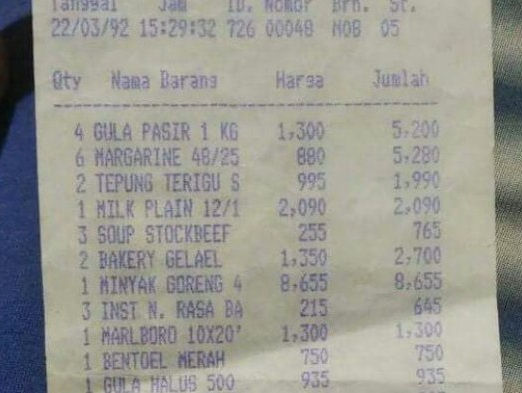

In [142]:
download_url = f"https://drive.google.com/uc?id=1bLYR6ZijSqpbqydFqLI3LDLQuD-eFES3&export=download"
output_filename = "struk_belanja.jpg"

# Perintah wget untuk mengunduh file
wget_command = f"wget --no-check-certificate '{download_url}' -O '{output_filename}'"
os.system(wget_command)

image = PILImage.open(output_filename)
image

In [152]:
response = client.models.generate_content(
    model=MODEL_ID,
    contents=[
        image,
        "apa daftar belanja yang tertulis di gambar?",
    ],
    config=types.GenerateContentConfig(
        system_instruction= "kamu akan selalu membaca tulisannya dalam bentuk table",
        seed=42
    )
)

Markdown(response.text)

Tentu, berikut adalah daftar belanja yang tertulis di gambar dalam bentuk tabel:

| Qty | Nama Barang         | Harga   | Jumlah   |
| --- | ------------------- | ------- | -------- |
| 4   | GULA PASIR 1 KG     | 1,300   | 5.200    |
| 6   | MARGARINE 48/25     | 880     | 5,280    |
| 2   | TEPUNG TERIGU S     | 995     | 1,990    |
| 1   | MILK PLAIN 12/1     | 2,090   | 2,090    |
| 3   | SOUP STOCKBEEF      | 255     | 765      |
| 2   | BAKERY GELAEL       | 1,350   | 2,700    |
| 1   | MINYAK GORENG 4     | 8.655   | 8.655    |
| 3   | INST N. RASA BA     | 215     | 645      |
| 1   | MARLBORO 10X20'     | 1,300   | 1,300    |
| 1   | BENTOEL MERAH       | 750     | 750      |
| 1   | GULA HALUS 500      | 935     | 935      |

In [162]:
print("Usage Metadata:")
usage_metadata = response.usage_metadata
for key, value in usage_metadata.__dict__.items():
  print(f"- {key}: {value}")

Usage Metadata:
- cache_tokens_details: None
- cached_content_token_count: None
- candidates_token_count: 128
- candidates_tokens_details: [ModalityTokenCount(modality=<MediaModality.TEXT: 'TEXT'>, token_count=128)]
- prompt_token_count: 1810
- prompt_tokens_details: [ModalityTokenCount(modality=<MediaModality.TEXT: 'TEXT'>, token_count=4), ModalityTokenCount(modality=<MediaModality.IMAGE: 'IMAGE'>, token_count=1806)]
- thoughts_token_count: None
- tool_use_prompt_token_count: None
- tool_use_prompt_tokens_details: None
- total_token_count: 1938
- traffic_type: None


### Menjelaskan Gambar Jumbo

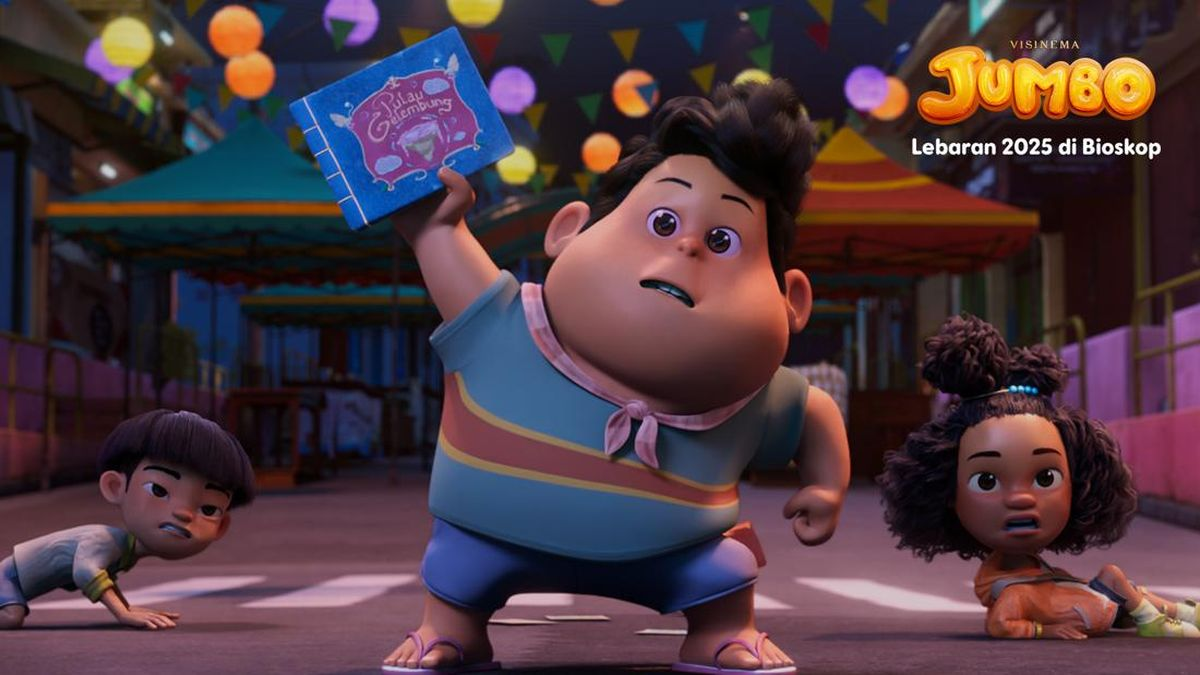

In [159]:
download_url = f"https://drive.google.com/uc?id=1y6tWv98bjM8MyzGFXbf2cb44R8_v1z0l&export=download"
output_filename = "jumbo.jpeg"

# Perintah wget untuk mengunduh file
wget_command = f"wget --no-check-certificate '{download_url}' -O '{output_filename}'"
os.system(wget_command)

image = PILImage.open('jumbo.jpeg')
image

In [161]:
response = client.models.generate_content(
    model=MODEL_ID,
    contents=[
        image,
        "Jelaskan gambar tersebut",
    ],
    config=types.GenerateContentConfig(
        seed=42
    )
)

Markdown(response.text)

Gambar tersebut adalah poster untuk film animasi berjudul "Jumbo." Poster ini menampilkan tiga karakter anak-anak di jalanan yang ramai. Di tengah, seorang anak laki-laki gemuk memegang buku berjudul "Pulau Gembung" dan terlihat terkejut. Di kiri, seorang anak laki-laki sedang merangkak di tanah dengan ekspresi cemberut. Di kanan, seorang anak perempuan duduk di tanah dengan ekspresi terkejut. Di bagian atas poster terdapat logo film "Jumbo" dan tulisan "Visinema." Di bawah logo terdapat tulisan "Lebaran 2025 di Bioskop," yang menunjukkan tanggal rilis film.

In [163]:
print("Usage Metadata:")
usage_metadata = response.usage_metadata
for key, value in usage_metadata.__dict__.items():
  print(f"- {key}: {value}")

Usage Metadata:
- cache_tokens_details: None
- cached_content_token_count: None
- candidates_token_count: 128
- candidates_tokens_details: [ModalityTokenCount(modality=<MediaModality.TEXT: 'TEXT'>, token_count=128)]
- prompt_token_count: 1810
- prompt_tokens_details: [ModalityTokenCount(modality=<MediaModality.TEXT: 'TEXT'>, token_count=4), ModalityTokenCount(modality=<MediaModality.IMAGE: 'IMAGE'>, token_count=1806)]
- thoughts_token_count: None
- tool_use_prompt_token_count: None
- tool_use_prompt_tokens_details: None
- total_token_count: 1938
- traffic_type: None


## Audio

In [213]:
def read_mp3(file_path):
  """Reads audio content from an MP3 file."""
  try:
    audio = AudioSegment.from_mp3(file_path)
    return audio
  except Exception as e:
    print(f"Error reading MP3 file: {e}")
    return None

download_url = f"https://drive.google.com/uc?id=1ZqhQQ43WPZTBK4a7fAYGNFq7cJUmf4nJ&export=download"
output_filename = "proklamasi.mp3"

# Perintah wget untuk mengunduh file
wget_command = f"wget --no-check-certificate '{download_url}' -O '{output_filename}'"
os.system(wget_command)

audio_path = pathlib.Path('State_of_the_Union_Address_30_January_1961.mp3')
audio_content = read_mp3(audio_path)
audio_path.write_bytes(audio_content.raw_data)

file_upload = client.files.upload(file=audio_path)

audio_content

ValueError: Failed to upload file: Upload status is not finalized.

In [215]:
# Prepare the file to be uploaded
AUDIO = "https://storage.googleapis.com/generativeai-downloads/data/State_of_the_Union_Address_30_January_1961.mp3"  # @param {type: "string"}
audio_bytes = requests.get(AUDIO).content

audio_path = pathlib.Path('audio.mp3')
audio_path.write_bytes(audio_bytes)

file_upload = client.files.upload(file=audio_path)

In [217]:
response = client.models.generate_content(
    model=MODEL_ID,
    contents=[
        file_upload,
        "Dengarkan dengan seksama lalu tulis teks yang dibacakan"
    ]
)

Markdown(response.text)

The President's State of the Union address to a joint session of the Congress from the rostrum of the House of Representatives, Washington DC, January 30th, 1961.

(Applaus)

Mr. Vice President, members of the Congress, it is a pleasure to return from whence I came.

(Applaus)

You are among my oldest friends in Washington, and this House is my oldest home. It was here

(Applaus)

It was here more than 14 years ago, that I first took the oath of federal office. It was here for 14 years, that I gained both knowledge and inspiration from members of both parties in both Houses, from your wise and generous leaders, and from the pronouncements which I can vividly recall sitting where you now sit, including the programs of two great presidents, the undimmed eloquence of Churchill, the soaring idealism of Nehru, the steadfast words of General de Gaulle. To speak from this same historic rostrum is a sobering experience. To be back amongst so many friends is a happy one.

I am confident that that friendship will continue. Our constitution wisely assigns both joint and separate roles to each branch of the government. And a president and a Congress who hold each other in mutual respect will neither permit nor attempt any trespass. For my part, I shall withhold from neither the Congress nor the people any fact or report past, present or future which is necessary for an informed judgment of our conduct and hazards.

(Applaus)

I shall neither shift the burden of executive decisions to the Congress, nor avoid responsibility for the outcome of those decisions.

(Applaus)

I speak today in an hour of national peril and national opportunity. Before my term has ended, we shall have to test anew whether a nation organize organized and governed such as ours can endure. The outcome is by no means certain. The answers are by no means clear. All of us together, this administration, this Congress, this nation must forge those answers. But today, were I to offer after a little more than a week in office, detailed legislation to remedy every national ill, the Congress would rightly wonder whether the desire for speed had replaced the duty of responsibility.

My remarks therefore will be limited, but they will also be candid. To state the facts frankly is not to despair the future nor indict the past. The prudent air takes careful inventory of his legacies, and gives a faithful accounting to those whom he owes an obligation of trust. And while the occasion does not call for another recital of our blessings and assets, we do have no greater asset than the willingness of a free and determined people, through its elected officials to face all problems frankly and meet all dangers, free from panic or fear. The present state of our economy is disturbing. We take office in the wake of seven months of recession, three and one half years of slack, seven years of diminished economic growth, and nine years of falling farm income.

Business bankruptcies have reached their highest level since the Great Depression. Since 1951, farm income has been squeezed down by 25%. Save for a brief period in 1958, insured unemployment is at the highest peak in our history. Of some five and one half million Americans who are without jobs, more than 1 million have been searching for work for more than four months. And during each month some 150,000 workers are exhausting their already meager jobless benefit rights. Nearly one eight of those who are without jobs live almost without hope in nearly 100 specially distressed and troubled areas. The rest include new school graduates, unable to use their talents, farmers forced to give up their part-time jobs which help balance their family budgets, skilled and unskilled workers laid off in such important industries as metals, machinery, automobiles and apparel. Our recovery from the 1958 recession moreover was anemic and incomplete.

Our gross national product never regained its full potential. Unemployment never returned to normal levels. Maximum use of our national industrial capacity was never fully restored. In short, the American economy is in trouble. The most resourceful industrialized country on earth ranks among the last in the rate of economic growth. Since last spring, our economic growth rate has actually declined. Business investment is in a decline. Profits have fallen below predicted levels. Construction is off. A million unsold automobiles are an inventory. Fewer people are working and the average work week has shrunk well below 40 hours. Yet prices have continued to rise so that now too many Americans have less to spend for items that cost more to buy. Economic prophecy is at best an uncertain art. As demonstrated by the prediction one year ago from this same podium, that 1960 would be and I quote the most prosperous year in our history, unquote.

Nevertheless, forecasts of continued slack and only slightly reduced unemployment through 1961 and 1962 have been made with alarming unanimity and this administration does not intend to stand helplessly by.

(Applaus)

We cannot afford to waste idle hours and empty plants while awaiting the reend of the recession. We must show the world what a free economy can do to reduce unemployment, to put unused capacity to work, to spur new productivity and to foster high and economic growth within a range of sound fiscal policies and relative price stability. I will propose to the Congress within the next 14 days, measures to improve unemployment compensation, through temporary increases in duration on a self-supporting basis, to provide more food for the families of the unemployed and to aid their needy children, to redevelop our areas of chronic labor surplus, to expand the services of the US employment office, to stimulate housing and construction, to secure more purchasing power for our lowest paid workers by raising and expanding the minimum wage, to offer tax incentives for sound plant investment, to increase the development of our natural resources, to encourage price stability and to take other steps aimed at ensuring a prompt recovery and paving the way for increased long-range growth. This is not a partisan program concentrating on our weaknesses. It is, I hope a national program to realize our national strength.

(Applaus)

Efficient expansion at home, stimulating the new plant and technology, that can make our goods more competitive is also the key to the international balance of payment problem. Laying aside all talk and solutions. Let us put that knotty problem in its proper perspective. It is true that since 1958 the gap between the dollars we spend or invest abroad and the dollars returned to us has substantially widened. This overall deficit in our balance of payments increased by nearly $11 billion in the last three years. And holders of dollars abroad converted them to gold in such a quantity as to cause a total outflow of nearly $5 billion of gold from our reserves. The 1959 deficit was caused in large part by our failure of our exports to penetrate foreign markets. The result both of restrictions on our goods and our own uncompetitive prices. The 1960 deficit on the other hand was more the result of an increase in private capital outflow, seeking new opportunity, higher return or speculative advantage abroad. Meanwhile, this country has continued to bear more than its share of the West's military and foreign aid obligations. Under existing policies another deficit of $2 billion is predicted for 1961. And individuals in those countries, whose dollar position once depended on these deficits for improvement, now wonder aloud whether our gold reserves will remain sufficient to meet our own obligations. All this is cause for concern, but it is not caused for panic. For our monetary and financial position remains exceedingly strong. Including our drawing rights in the International Monetary Fund and the gold reserve held as backing for our currency and federal reserve deposits, we have some $22 billion in total gold stocks and other international monetary reserves and I now pledge that their full strength stands behind the value of the dollar for use if needed.

(Applaus)

Moreover, we hold large assets abroad. The total owe this nation far exceeds the claim upon our reserves and our exports once again substantially exceed our imports. In short, we need not and we shall not take any action to increase the dollar price of gold from $35 an ounce.

To impose exchange controls, to reduce our anti-recession efforts, to fall back on restrictive trade policies or to weaken our commitments around the world. This administration will not distort the value of the dollar in any fashion and this is a commitment.

(Applaus)

Prudence and good sense do require however that new steps be taken to ease the payment deficits and prevent any gold crisis. Our success in world affairs has long depended in part upon foreign competence in our ability to pay. A series of executive orders, legislative remedies and cooperative efforts with our allies will get underway immediately aimed at attracting foreign investment and travel to this country, promoting American exports at stable prices and with more liberal government guarantees and financing, curbing tax and custom loopholes that encourage undue spending of private dollars abroad and through OECD, NATO and otherwise sharing with our allies all efforts to provide for the common defense of the free world and the hopes for growth of the less developed lands. While the current deficit loss, ways will be found to ease our dollar outlays abroad without placing the full burden on the families of men who we have asked to serve our flag overseas.

(Applaus)

In short, whatever is required will be done to back up all our efforts abroad and to make certain that in the future as in the past, the dollar is as sound as a dollar.

(Applaus)

But more than our exchange of international payments is out of balance. The current federal budget for fiscal 1961 is almost certain to show a net deficit. The budget already submitted for fiscal 1962 will remain in balance only if the Congress and acts all the revenue measures requested and only if an earlier and sharper upturn in the economy than my economic advisors now think likely produces the tax revenues estimated. Nevertheless, a new administration must of necessity build on the spending and revenue estimates already submitted. Within that framework, barring the development of urgent national defense needs or a worsening of the economy, it is my current intention to advocate a program of expenditures which including revenue from a stimulation of the economy will not of and by themselves unbalance the earlier budget. However, we will do what must be done. For our national household is cluttered with unfinished and neglected tasks. Our cities are being engulfed in squalla. 12 long years after Congress declared our goal to be a decent home and a suitable environment for every American family, we still have 25 million Americans living in substandard homes. A new housing program under a new housing and urban affairs department will be needed this year. Our classrooms contain 2 million more children than they can properly have room for taught by 90,000 teachers not properly qualified to teach. One third of our most promising high school graduates are financially unable to continue the development of their talents. The war babies of the 1940s who overcrowded our schools in the 1950s are now descending in 1960 upon our colleges with two college students for everyone 10 years from now and our colleges are ill prepared. We lack the scientists, the engineers, and the teachers our world obligations require. We have neglected oceanography, saline water conversion and the basic research that lies at the root of all progress. Federal grants for both higher and public school education can no longer be delayed.

(Applaus)

Medical research has achieved new wonders, but these wonders are too often beyond the reach of too many people owing to a lack of income particularly among the aged, a lack of hospital beds, a lack of nursing homes and a lack of doctors and dentists. Measures to provide healthcare for the aged under social security and to increase the supply of both facilities and personnel must be undertaken this year.

(Applaus)

Our supply of clean water is dwindling. Organized and juvenile crime cost the taxpayers millions of dollars every year making it essential that we have improved enforcement and new legislative safeguards. The denial of constitutional rights to some of our fellow Americans on account of race at the ballot box and elsewhere disturbs the national conscience and subjects us to the charge of world opinion that our democracy is not equal to the high promise of our heritage. Morality in private business has not been sufficiently spurred by morality in public business. A host of problems and projects in all 50 states, though not possible to include in this message deserves and will receive the attention of both the Congress and the executive branch. On most of these matters, messages will be sent to the Congress within the next two weeks.

But all these problems pale when placed besides those which confront us around the world. No man entering upon this office, regardless of his party, regardless of his previous service in Washington could fail to be staggered upon learning even this brief 10 day period, the harsh enormities of the trials through which we must pass in the next four years. Each day the crisis multiply. Each day their solution grows more difficult. Each day we draw nearer the hour of maximum danger as weapons spread and hostile forces grow stronger. I feel I must inform the Congress that our analysis over the next last 10 days make it clear that in each of the principle areas of crisis, the tide of events has been running out and time has not been our friend. In Asia, the relentless pressures of the Chinese communists menace the security of the entire area from the borders of India and South Vietnam to the jungles of Laos, struggling to protect its newly won independence.

We seek in Laos what we seek in all Asia and indeed in all of the world freedom for the people and independence for the government. And this nation shall persevere in our pursuit of these objectives.

(Applaus)

In Africa, the Congo has been brutally torn by civil strife, political unrest and public disorder. We shall continue to support the heroic efforts of the United Nations to restore peace and order efforts which are now endangered by mounting tensions, unsolved problems and decreasing support from many member states. In Latin America, communist agents seeking to exploit that region's peaceful revolution of hope have established a base on Cuba only 90 miles from our shore. Our objection with Cuba is not over the people's drive for a better life. Our objection is to their domination by foreign and domestic tyrannies.

(Applaus)

Cuban social and economic reforms should be encouraged. Questions of economics and trade policy can always be negotiated, but communist domination in this hemisphere can never be negotiated.

(Applaus)

We are pledged to work with our sister republics to free the Americas of all such foreign domination and all tyranny working towards the goal of a free hemisphere of free governments, extending from Cape Horn to the Arctic Circle.

(Applaus)

In Europe our alliances are unfulfilled and in some disarray. The unity of NATO has been weakened by economic rivalry and partially eroded by national interest. It has not yet fully mobilized its resources nor fully achieved a common outlook. Yet no Atlantic power can meet on its own the mutual problems now facing us in defense, foreign aid, monetary reserves, and a host of other areas and our close ties with those whose hopes and interest we share are among this nation's most powerful assets. Our greatest challenge is still the world that lies beyond the Cold War. But the first great obstacle is still our relations with the Soviet Union and communist China. We must never be lured into believing that either power has yielded its ambitions for world domination. Ambitions which they forcefully restated only a short time ago. On the contrary, our task is to convince them that aggression and subversion will not be profitable routes to pursue these ends. Open and peaceful competition for prestige for markets for scientific achievement, even for men's minds is something else again. For if freedom and communism would compete for man's allegiance in a world at peace, I would look to the future with ever increasing confidence.

(Applaus)

To meet this array of challenges, to fulfill the role we cannot avoid on the world scene, we must reexamine and revise our whole arsenal of tools. One must not overshadow the other. On the presidential code of arms, the American eagle holds in his right talent the olive branch while in his left he holds a bundle of arrows. We intend to give equal attention to both.

(Applaus)

First, we must strengthen our military tools. We are moving into a period of uncertain risk and great commitment in which both the military and diplomatic possibilities require a free world force so powerful as to make any aggression clearly futile. Yet in the past, lack of a consistent coherent military strategy, the absence of basic assumptions about our national requirements and the faulty estimate and duplication arising from interservice rivalries have all made it difficult to assess accurately how adequate or inadequate our defenses really are. I have therefore instructed the Secretary of Defense to re-appraise our entire defense strategy. Our ability to fulfill our commitments. The effectiveness, vulnerability and dispersal of our strategic bases, forces and warning systems. The efficiency and economy of our operation and organization. The elimination of obsolete bases and installations and the adequacy, modernization and mobility of our present conventional and nuclear forces and weapon systems in the light of present and future dangers. I have asked for preliminary conclusions by the end of February and I then shall recommend whatever legislative, budgetary or executive action is needed in the light of these conclusions. In the meantime, I have asked the defense secretary to initiate immediately three steps most clearly needed now. First, I have directed prompt attention to increase our airlift capacity, obtaining additional air transport mobility and obtaining it now will better assure the ability of our conventional forces to respond without discrimination and speed with discrimination and speed to any problem at any spot on the globe at any moment's notice.

(Applaus)

In particular, it will enable us to meet any deliberate effort to avoid or divert our forces by starting limited wars in widely scattered parts of the globe. Be I've directed prompt action to step up our Polaris submarine program. Using using unobligated shipbuilding funds now to let contracts originally scheduled for the next fiscal year will build and place on station at least nine months earlier than planned substantially more units of a crucial deterrent. A fleet that will never attack first but possess sufficient powers of retaliation concealed beneath the sea to discourage any aggressor from launching an attack upon our security.

See I've directed prompt action to accelerate our entire missile program. Until the Secretary of Defense's reappraisal is completed, the emphasis here will be largely on improved organization and decision making. On cutting down the wasteful duplications and the time lag that have handicapped our whole family of missiles. If we are to keep the peace, we need an invulnerable missile force powerful enough to deter any aggressor from even threatening an attack that he would know could not destroy enough of our own forces to prevent his own destruction. For as I said upon taking the oath of office, only when our arms are sufficient beyond doubt can we be certain beyond doubt that they will never be employed.

Secondly, we must improve our economic tools. Our role is essential and unavoidable in the construction of a sound and expanding economy for the entire non-communist world. Helping other nations build the strength to meet their own problems, to satisfy their own aspirations, to surmount their own dangers. The problems in achieving this goal are towering and unprecedented. The response must be towering and unprecedented as well much as lease and the Marshall plan were in earlier years which brought such fruitful results. I intend to ask the Congress for authority to establish a new and more effective program for assisting the economic, educational and social development of other countries and continents. That program must stimulate and take more effectively into account the contributions of our allies and provide central policy direction for all our own programs that now so often overlap, conflict or diffuse our energies and resources. Such a program compared to past programs will require more flexibility for short run emergencies, more commitment to long-term development, new attention to education at all levels, greater emphasis on the recipient nation's role, their effort, their purpose with greater social justice for their people, a broader distribution and participation by their people and more efficient public administration and more efficient tax systems of their own. And orderly planning for national and regional development instead of a piecemeal approach. I hope the Senate will take early action, approving the convention establishing the organization for Economic Cooperation and development. This will be an important instrument in sharing with our allies this development effort working towards the time when each nation will contribute in proportion to its ability to pay. For while we are prepared to assume our full share of these huge burdens, we cannot and must not be expected to bear them alone.

To our sister republics of the South, we have pledged a new alliance for progress. Alianza Para Progreso. Our goal is a free and prosperous Latin America, realizing for all its states and all its citizens a degree of economic and social progress that matches their historic contributions of culture, intellect and liberty. To start this nation's role at this time in that alliance of neighbors, I am recommending the following: that the Congress appropriate in full the $500 million fund pledged by the act of Bogota to be used not as an instrument of the Cold War, but as a first step in the sound development of the Americas. That a new interdepartmental task force be established under the leadership of the Department of State to coordinate at the highest level all policies and programs of concern to the Americas. That our delegates to the OAS working with those of other members, strengthen that body as an instrument to preserve the peace and to prevent foreign domination anywhere in the hemisphere. That in cooperation with other nations, we launch a new hemispheric attack on illiteracy and an adequate educational opportunities at all levels. And finally that a food for peace mission be sent immediately to Latin America to explore ways in which our vast food abundance can be used to help hunger and malnutrition in certain areas of suffering in our own hemisphere.

This administration is expanding its food for peace program in every possible way. The product of our abundance must be used more effectively to relieve hunger and help economic growth in all corners of the globe. And I have asked the director of this program to recommend additional ways in which these surplus can advance the interest of world peace including the establishment of world food reserves. An even more valuable national asset is our reservoir of dedicated men and women. Not only at our college campuses but in every age group who have indicated their desire to contribute their skills, their efforts and a part of their lives to the fight for world order. We can mobilize this talent through the formation of a national peace core, enlisting the services of all those with desire and capacity to help foreign lands meet their urgent needs for trained personnel. Finally, while our attention is centered on the development of the non-communist world, we must never forget our hopes for the ultimate freedom and welfare of the Eastern European people.

In order to be prepared to help reestablish historic ties of friendship, I am asking the Congress for increased discretion to use economic tools in this area whenever this is found to be clearly in the national interest. This will require amendment of the mutual defense assistance control Act along the lines I proposed as a member of the Senate and upon which the Senate voted last summer. Meanwhile, I hope to explore with the Polish government the possibility of using our frozen Polish funds on projects of peace that will demonstrate our abiding friendship and interest in the people of Poland.

Third, we must sharpen our political and diplomatic tools. The means of cooperation and agreement on which an enforcable world order must ultimately rest. I have already taken steps to coordinate and expand our disarmament effort to increase our programs of research and study and to make arms control a central goal of our national policy under my direction. The deadly arms race and the huge resources it absorbs have too long overshadowed all else we must do. We must prevent that arms racing from spreading to new nations to new nuclear power powers and to the outer reaches of space. We must make certain that our negotiators are better informed and better prepared to formulate workable proposals of our own and to make sound judgment about the proposals of others. I have asked the other governments concerned to agree to a reasonable delay in the talks on a nuclear test ban and it is our intention to resume negotiations prepared to reach a final agreement with any nation that is equally willing to agree to an effective and enforcable treaty.

We must increase our support of the United Nations as an instrument to end the Cold War instead of an arena in which to fight it. In recognition of its increasing importance and the doubling of its membership, we are enlarging and strengthening our own mission to the UN. We shall help ensure that it is properly financed. We shall work to see that the integrity of the office of the Secretary General is maintained.

And I would address a special plea to the smaller nations of the world to join with us in strengthening this organization, which is far more essential to their security than it is to ours. The only body in the world where no nation need be powerful to be secure, where every nation has an equal voice and where any nation can exert influence not according to the strength of its armies, but according to the strength of its ideas. It deserves the support of all.

Finally, this administration intends to explore promptly all possible areas of cooperation with the Soviet Union and other nations to invoke the wonders of science instead of its terrors. Specifically, I now invite all nations, including the Soviet Union to join with us in developing a weather prediction program in a new communications satellite program and in preparation for probing the distant planets of Mars and Venus. Probes which may someday unlock the deepest secrets of the universe. Today this country is ahead in the science and technology of space while the Soviet Union is ahead in the capacity

While the Soviet Union is ahead in the capacity to lift large vehicles into orbit. Both nations would help themselves as well as other nations by removing these endeavors from the bitter and wasteful competition of the Cold War. The United States would be willing to join with the Soviet Union and the scientists of all nations in a greater effort to make the fruits of this new knowledge available to all. And beyond that, in an effort to extend farm technology to hungry nations, to wipe out disease, to increase the exchanges of scientists and knowledge and our make our own laboratories available to technicians of other lands who lack the facilities to pursue their own work where nature makes natural allies of us all, we can demonstrate that beneficial relations are possible even with those with whom we most deeply disagree and this must someday be the basis of world peace and world law.

I have commented on the state of the domestic economy, our balance of payments, our federal and social budget and the state of the world. I would like to conclude with a few remarks about the state of the executive branch. We have found it full of honest and useful public servants. But their capacity to act decisively at the exact time action is needed has too often been muffled in the morass of committees, timidities and fictitious theories which have created a growing gap between decision and execution, between planning and reality. In a time of rapidly deteriorating situations at home and abroad, this is bad for the public service and particularly bad for the country and we mean to make a change.

I have pledged myself and my colleagues in the cabinet to a continuous encouragement of initiative, responsibility and energy in serving the public interest. Let every public servant know whether his post is high or low that a man's rank and reputation in this administration will be determined by the size of the job he does and not by the size of his staff, his office or his budget.

Let it be clear that this administration recognizes the value of descent and daring that we greet healthy controversy as the hallmark of healthy change. Let the public service be a proud and lively career. And let every man and woman who works in any area of our national government, in any branch, at any level be able to say with pride and with honor in future years, I serve the United States government in that hour of our nation's need. For only with complete dedication by us all to the national interest can we bring our country through the troubled years that lie ahead. Our problems are critical. The tide is unfavorable. The news will be worse before it is better. And while hoping and working for the best, we should prepare ourselves now for the worst. We cannot escape our dangers. Neither must we let them drive us into panic or narrow isolation. In many areas of the world where the balance of power already rests with our adversaries, the forces of freedom are sharply divided. It is one of the ironies of our time that the techniques of a harsh and repressive system should be able to instill discipline and otter in its servants while the blessings of liberty have too often stood for privilege, materialism and a life of ease, but I have a different view of liberty. Life in 1961 will not be easy. Wishing it, predicting it, even asking for it will not make it so. There will be further setbacks before the tide is turned, but turn it we must. The hopes of all mankind rest upon us. Not simply upon those of us in this chamber, but upon the peasant in Laos, the fisherman in Nigeria, the exile from Cuba. The spirit that moves every man and nation who shares our hopes for freedom and the future. And in the final analysis, they rest most of all upon the pride and perseverance of our fellow citizens of the great republic. In the words of a great president, whose birthday we honor today, closing his final state of the Union message 16 years ago. We pray that we may be worthy of the unlimited opportunities that God has given us.
(Applaus)


## Vidio

In [219]:
# Download the video file
VIDEO_URL = "https://download.blender.org/peach/bigbuckbunny_movies/BigBuckBunny_320x180.mp4"  # @param {type: "string"}
video_file_name = "BigBuckBunny_320x180.mp4"
!wget -O {video_file_name} $VIDEO_URL

# Upload the file using the API
video_file = client.files.upload(file=video_file_name)
print(f"Completed upload: {video_file.uri}")

--2025-05-15 20:06:54--  https://download.blender.org/peach/bigbuckbunny_movies/BigBuckBunny_320x180.mp4
Resolving download.blender.org (download.blender.org)... 172.67.14.163, 104.22.65.163, 104.22.64.163, ...
Connecting to download.blender.org (download.blender.org)|172.67.14.163|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 64657027 (62M) [video/mp4]
Saving to: ‘BigBuckBunny_320x180.mp4’

BigBuckBunny_320x18 100%[===================>]  61.66M   103MB/s    in 0.6s    

2025-05-15 20:06:55 (103 MB/s) - ‘BigBuckBunny_320x180.mp4’ saved [64657027/64657027]

Completed upload: https://generativelanguage.googleapis.com/v1beta/files/vdnelzkzkm67


In [220]:
import time

# Check the file processing state
while video_file.state == "PROCESSING":
    print('Waiting for video to be processed.')
    time.sleep(10)
    video_file = client.files.get(name=video_file.name)

if video_file.state == "FAILED":
  raise ValueError(video_file.state)
print(f'Video processing complete: ' + video_file.uri)

Waiting for video to be processed.
Video processing complete: https://generativelanguage.googleapis.com/v1beta/files/vdnelzkzkm67


In [221]:
# Ask Gemini about the video
response = client.models.generate_content(
    model=MODEL_ID,
    contents=[
        video_file,
        "Describe this video.",
    ]
)

Markdown(response.text)

The video opens with a picturesque animated landscape of a pinkish-hued sky, green fields, and lush trees. As the scenery unfolds, it transitions to a tranquil stream flowing through the landscape. A small bird perched on a branch is then shown, and shortly after, the title "The Peach Open Movie Project Presents" appears.

The camera pans to a rabbit's burrow nestled beneath a tree, leading to the title card: "Big Buck Bunny." The camera zooms into the burrow, revealing a hefty rabbit awakening from slumber. He emerges, stretches, and takes a leisurely stroll through the meadow, pausing to smell a cluster of white flowers. A butterfly lands on his head as he sprawls on the grass, basking in the sun.

Suddenly, an apple falls to the ground. Big Buck Bunny eyes it with a mix of hesitation and desire. Meanwhile, in a tree, a trio of squirrels surveil the scene. One of them drops the apple onto the rabbit, who is initially startled but soon determined.

The rabbit begins crafting a series of booby traps, and the squirrels find themselves ensnared. However, they retaliate, prompting an escalating series of pranks. Finally, the cunning rabbit deploys his ultimate trap, ensnaring the squirrels. Victorious, he celebrates his triumph.

The video concludes with the credits, accompanied by the mischievous squirrels flitting around the text. At the very end, the tired little bird from the beginning is seen sleeping on the squirrels' tree and, waking up from the commotion, falls off the branch.

## Youtube

In [224]:
response = client.models.generate_content(
    model=MODEL_ID,
    contents= types.Content(
        parts=[
            types.Part(text="Rangkum Vidio Berikut."),
            types.Part(
                file_data=types.FileData(file_uri='https://www.youtube.com/watch?v=kWqjY_h3TPs')
            )
        ]
    ),
    config=types.GenerateContentConfig(
        seed=42
    )
)

Markdown(response.text)

Tentu, berikut adalah rangkuman dari video tersebut.

Video ini adalah pengenalan tentang Gemini Academy dan apa yang akan dipelajari dalam modul ini.

Fardi Yandi, sang pembawa acara, membahas tiga lesson penting:
1. Mengumpulkan ide-ide bisnis yang menarik dan tips membuat konten
2. Otomatisasi tugas yang membosankan dan cara menggunakan Social SEO.
3. Menggunakan AI sebagai asisten penjualan pribadi yang bisa dimanfaatkan untuk sales bisnis.

Dalam video ini, Fardi memberikan tips dan trik, panduan untuk membangun marketing sales,  berbisnis di Media Sosial, dan menggunakan AI sebagai asisten penjualan.

# Membikin konten

## Generate Text

In [240]:
prompt = "Pada suatu hari hiduplah seorang anak.."

response_cerita = client.models.generate_content(
    model=MODEL_ID,
    contents=prompt,
    config=types.GenerateContentConfig(
        system_instruction=[
            "Kamu adalah seorang pendongeng.",
            "Tugas kamu melanjutkan cerita yang diberikan dengan menggambarkan suasana sedetail mungkin dalam 1 paragraph."
        ],
        seed=42
    )
)

Markdown(response_cerita.text)

Sebagai gambaran visual dari narasi tersebut, saya akan menciptakan ilustrasi yang menampilkan seorang anak bernama Astra yang berdiri di dalam stasiun antariksa futuristik. Astra, seorang anak kecil dengan tatapan penuh keingintahuan, akan terlihat sedang mengamati planet Bumi yang tampak jauh melalui jendela kaca stasiun yang besar. Interior stasiun akan dipenuhi dengan teknologi canggih, panel-panel bercahaya, dan instalasi hidroponik dengan tanaman hijau yang tumbuh subur, menciptakan kontras yang menarik dengan pemandangan gelap dan berbintang di luar. Cahaya matahari akan memancar masuk, memantul pada permukaan metalik stasiun dan memberikan sentuhan warna hangat pada pemandangan.



In [242]:
prompt = "Pada suatu hari hiduplah seorang anak yang hidup di luar angkasa.."

response_cerita = client.models.generate_content(
    model=MODEL_ID,
    contents=prompt,
    config=types.GenerateContentConfig(
        system_instruction=[
            "Kamu adalah seorang pendongeng.",
            "Tugas kamu melanjutkan cerita yang diberikan dengan menggambarkan suasana sedetail mungkin dalam 1 paragraph."
        ],
        seed=42
    )
)

Markdown(response_cerita.text)

Pada suatu hari, di tengah hamparan bintang yang tak berujung, tinggallah seorang anak yang bernama Astra. Rumahnya bukanlah bumi yang hijau dan biru, melainkan sebuah stasiun luar angkasa yang mengorbit nebula Orion yang megah. Di balik jendela-jendela besar stasiun, Astra menyaksikan tarian kosmik yang memukau: awan debu dan gas berwarna-warni yang berkilauan seperti lukisan abstrak raksasa. Sesekali, kilatan meteor melesat melintasi kegelapan, meninggalkan jejak cahaya yang membara. Astra, dengan rambut seputih bintang dan mata yang berkilau seperti galaksi, merasa damai di tengah kesunyian antariksa, namun hatinya menyimpan kerinduan untuk petualangan yang lebih jauh, melampaui batas stasiun tempat ia dilahirkan.


## Generate image

I will generate an image depicting a young child named Astra with white hair and galaxy-like sparkling eyes, gazing out of a large window in a space station. The station orbits the magnificent Orion Nebula, visible through the window as a vast, colorful cloud of dust and gas. Occasional streaks of meteorites will flash across the dark expanse of space outside, creating trails of light. The overall scene will evoke a sense of peaceful solitude and a longing for adventure in the child's expression as they observe the cosmic ballet.


image/png


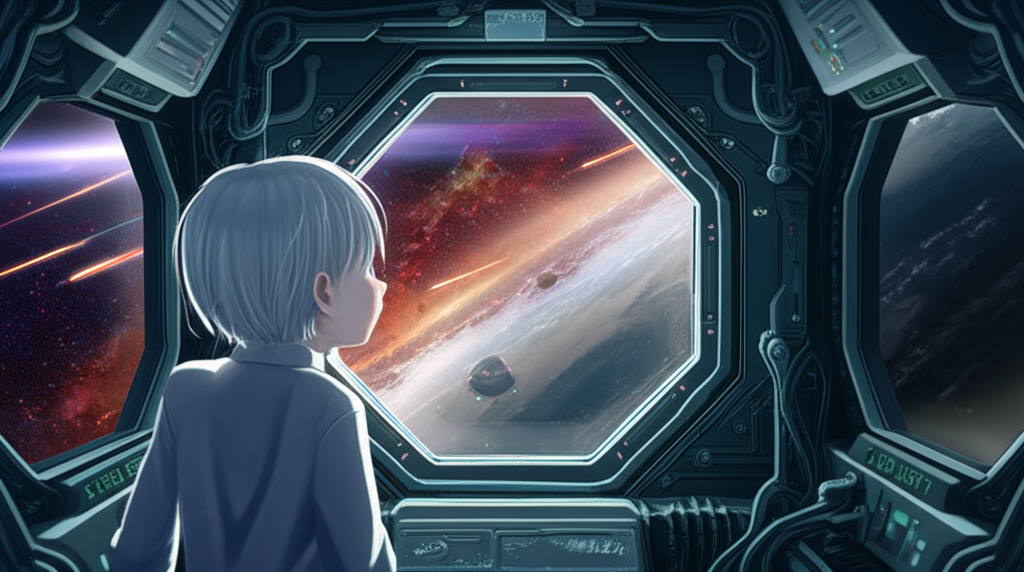

In [247]:
prompt = response_cerita.text

response = client.models.generate_content(
    model="gemini-2.0-flash-exp",
    contents=prompt,
    config=types.GenerateContentConfig(
        response_modalities=['Text', 'Image'],
        seed=42
    )
)

for part in response.candidates[0].content.parts:
  if part.text is not None:
    display(Markdown(part.text))
  elif part.inline_data is not None:
    mime = part.inline_data.mime_type
    print(mime)
    data = part.inline_data.data
    display(Image(data=data))